In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.gnn as gnn
import model.util as model_util
import model.generate as generate
import analysis.graph_metrics as graph_metrics
import analysis.mmd as mmd
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
node_dim = 1

dataset = random_graph_dataset.RandomGraphDataset(
    node_dim, num_items=6400,
    graph_type="community"
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=0  # TODO: allow multi-processing
)

In [4]:
mmd_sample_size = 200

### Import the model

In [5]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliZeroSkipDiffuser(100, 10, (1,))  # Make input shape just 1
t_limit = 1000

base_path = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models"
model_path = os.path.join(base_path, "community-small_edge-deletion", "1", "epoch_100_ckpt.pth")

model = model_util.load_model(gnn.GraphLinkGAT, model_path).to(DEVICE)

### Generate graphs without control

In [6]:
def sample_prior():
    """
    Samples from the prior distribution. Returns a batch as a Data object.
    """
    data = next(iter(data_loader))
    edges = graph_conversions.pyg_data_to_edge_vector(data)
    sampled_edges = diffuser.sample_prior(
        edges.shape[0], # Samples will be E x 1
        torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
    )[:, 0]  # Shape: E
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)
    return data

In [7]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

graph_samps_no_cont = []

while len(graph_samps_no_cont) < mmd_sample_size:
    prior = sample_prior()
    samples_no_cont = generate.generate_graph_samples(
        model, diffuser, prior, t_limit=t_limit, verbose=True
    )
    
    # Split samples into individual graphs
    graph_samps_no_cont.extend(
        graph_conversions.split_pyg_data_to_nx_graphs(samples_no_cont)
    )

graph_samps_no_cont = graph_samps_no_cont[:mmd_sample_size]

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


Sampling some reverse trajectories


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.38it/s]


0


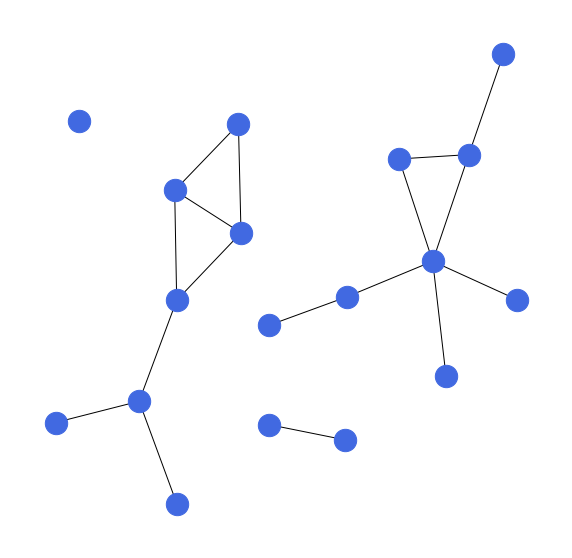

1


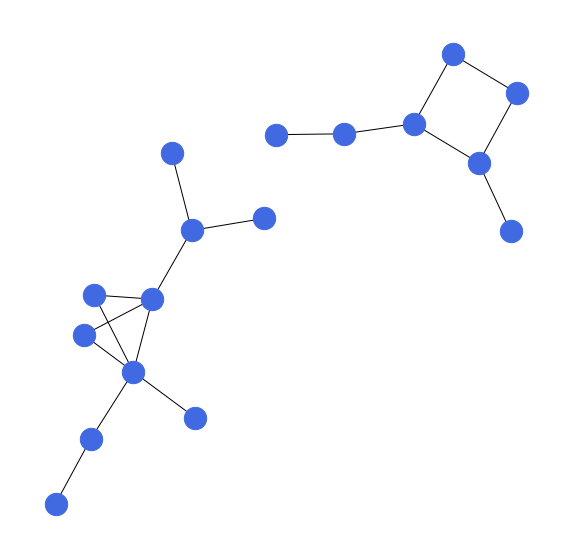

2


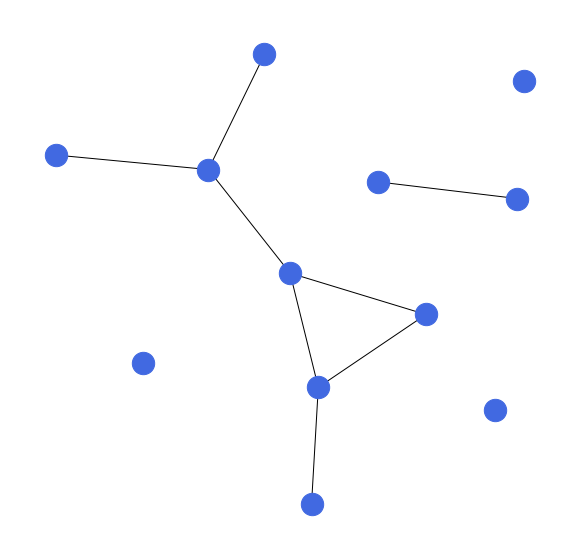

3


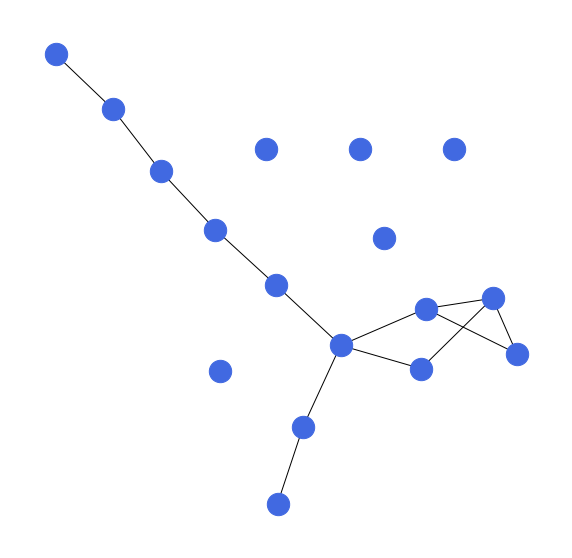

4


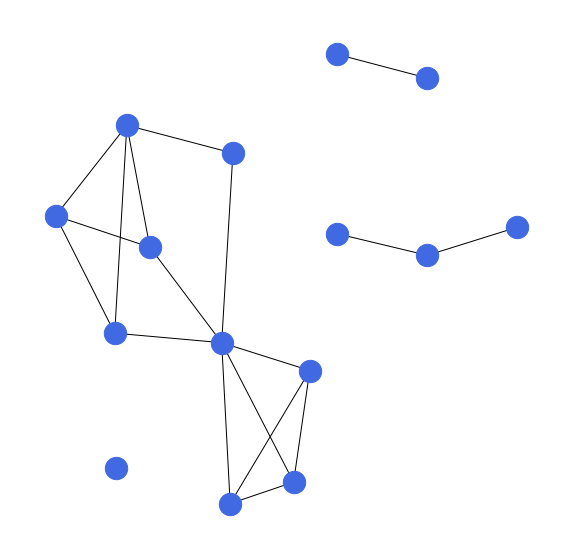

5


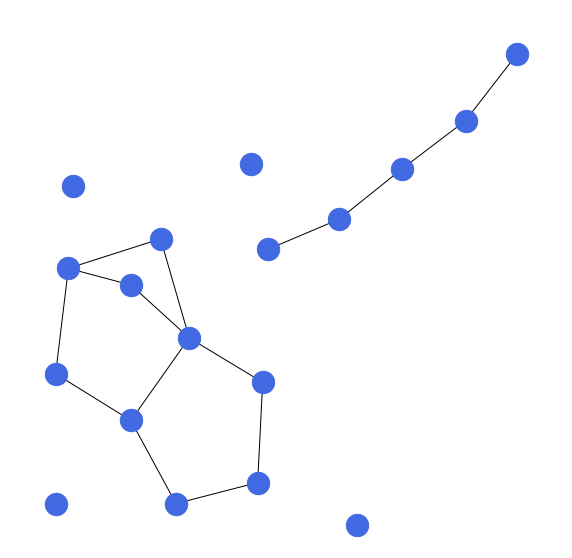

6


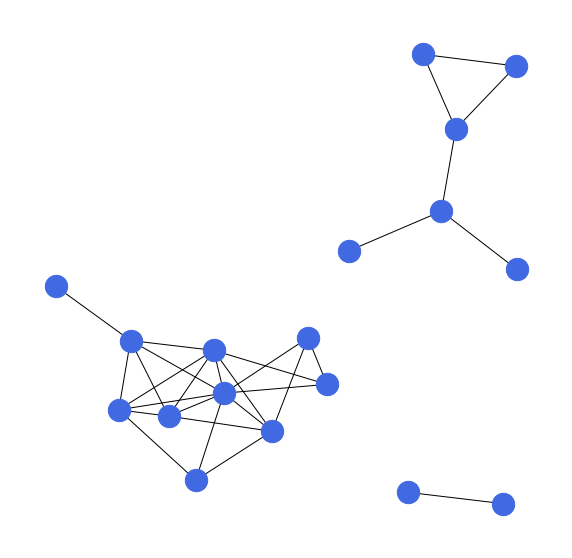

7


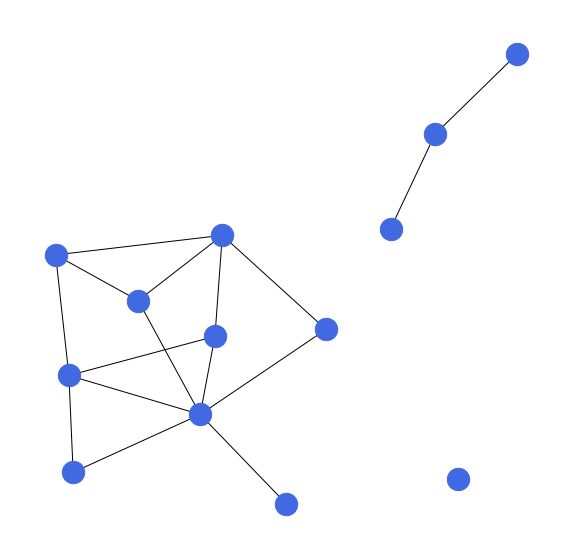

8


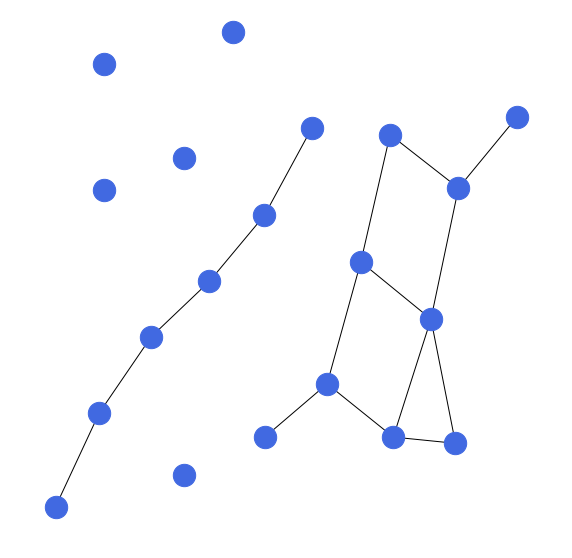

9


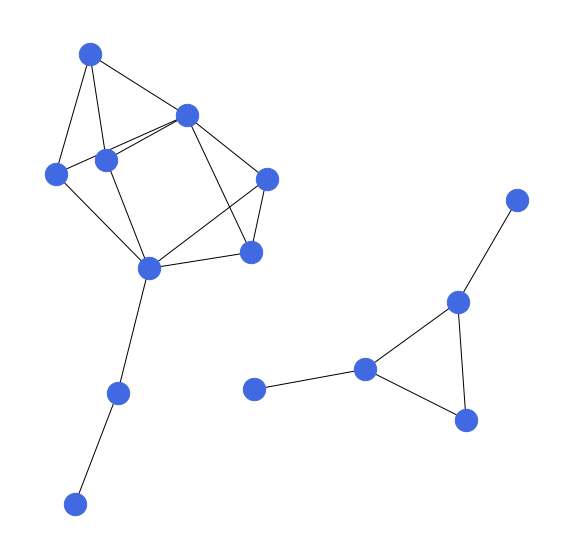

In [8]:
# Plot some randomly generated graphs
for i, g in enumerate(graph_samps_no_cont[:10]):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=nx.nx_pydot.graphviz_layout(g), ax=ax, node_size=500, node_color="royalblue")
    plt.show()

### Generate graphs with control

In [9]:
graph_samps_with_cont = []

while len(graph_samps_with_cont) < mmd_sample_size:
    prior = sample_prior()

    # Pick a single clique to retain in each graph
    # TODO: this is still rather inefficient
    all_edges_inds = graph_conversions.edge_vector_to_pyg_data(prior, 1, reflect=False)
    all_edges_vec = graph_conversions.pyg_data_to_edge_vector(prior)
    assert all_edges_inds.shape[1] == all_edges_vec.shape[0]
    discard_mask = torch.full(all_edges_vec.shape, False)
    for i in range(len(prior.ptr) - 1):
        start, end = prior.ptr[i], prior.ptr[i + 1]

        # Arbitrarily make the first and latter halves communities
        half = (start + end) // 2
        for ind_1 in range(start, half):
            for ind_2 in range(half, end):
                m = (all_edges_inds[0, :] == ind_1) & (all_edges_inds[1, :] == ind_2)
                assert torch.sum(m).item() == 1
                discard_mask[m] = True

    # Go through sampling procedure
    data_t = prior
    for t in tqdm.notebook.trange(t_limit, 0, -1):
        data_t = generate.generate_graph_samples(
            model, diffuser, data_t, t_limit=t, t_start=(t - 1)
        )

        # Make sure the edges we want to exist will exist
        edges_t = graph_conversions.pyg_data_to_edge_vector(data_t)
        edges_t[discard_mask] = 0
        data_t.edge_index = graph_conversions.edge_vector_to_pyg_data(data_t, edges_t)

    # Split samples into individual graphs
    graph_samps_with_cont.extend(
        graph_conversions.split_pyg_data_to_nx_graphs(data_t)
    )

graph_samps_with_cont = graph_samps_with_cont[:mmd_sample_size]

/local/61263940/ipykernel_11833/809743772.py:16: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half = (start + end) // 2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0


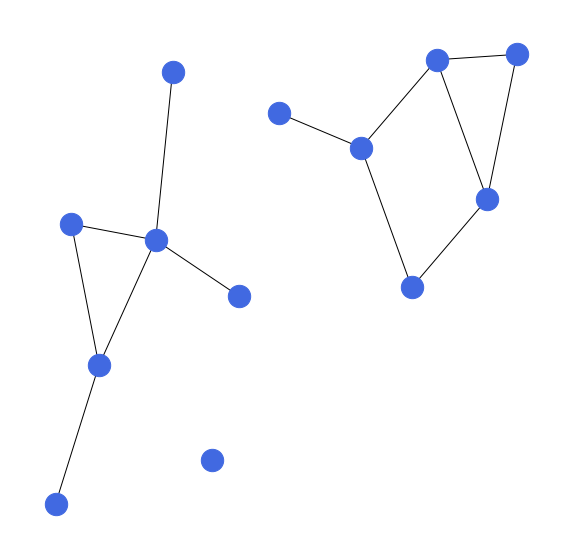

1


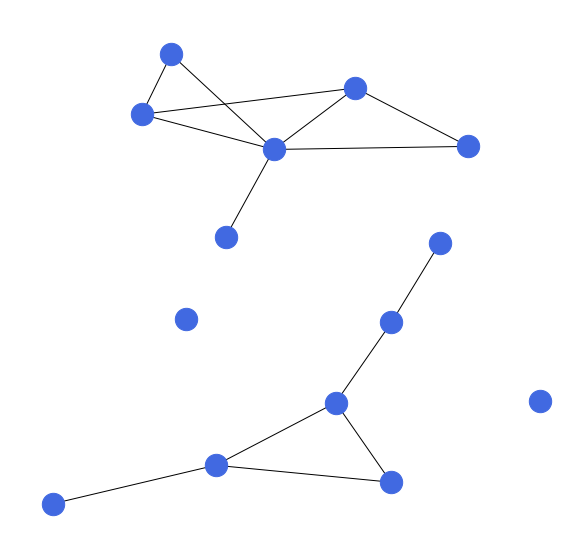

2


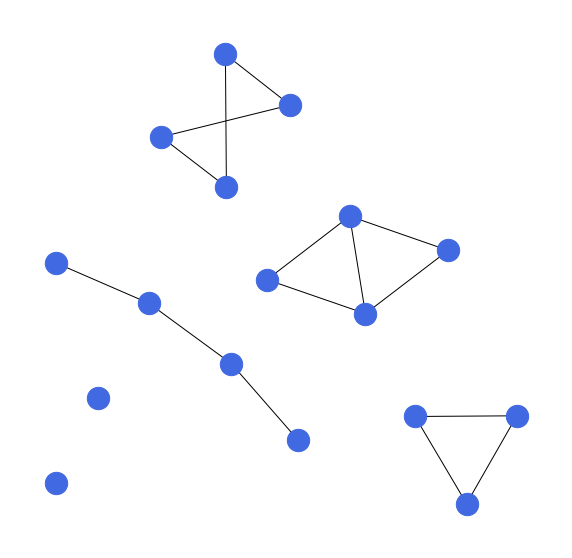

3


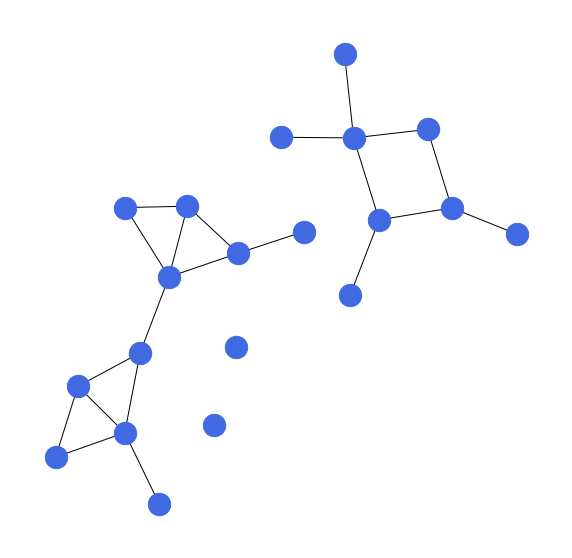

4


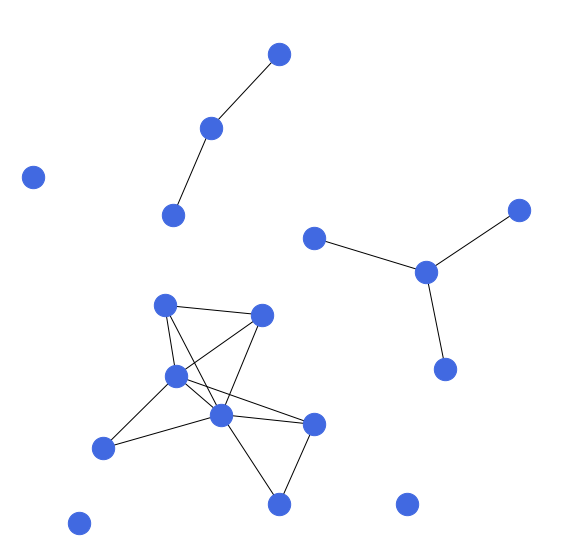

5


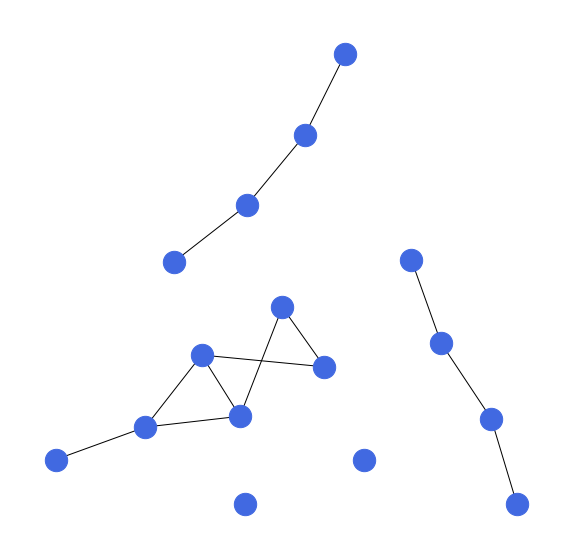

6


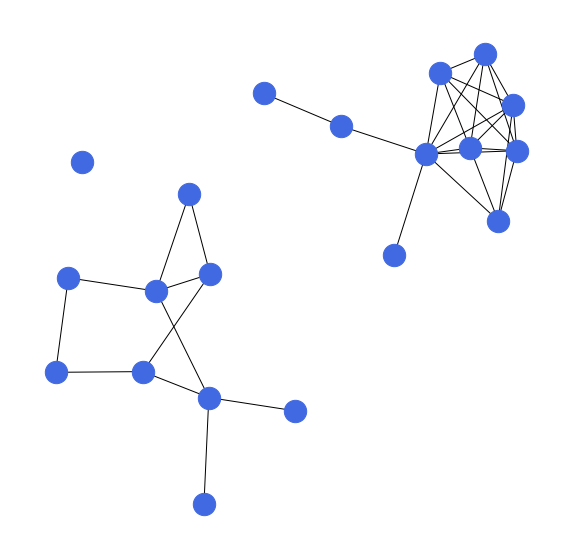

7


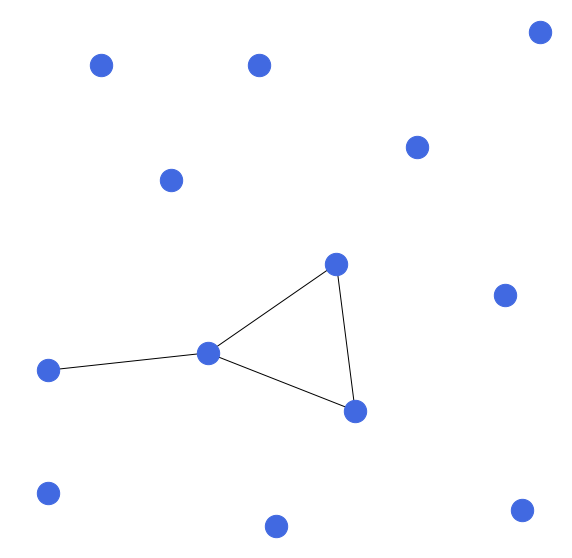

8


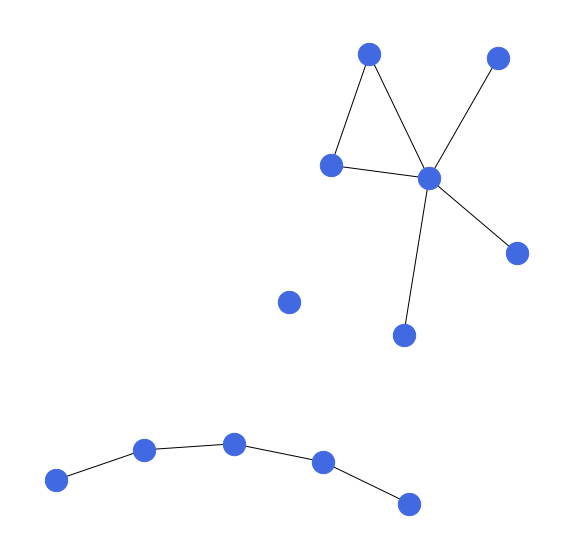

9


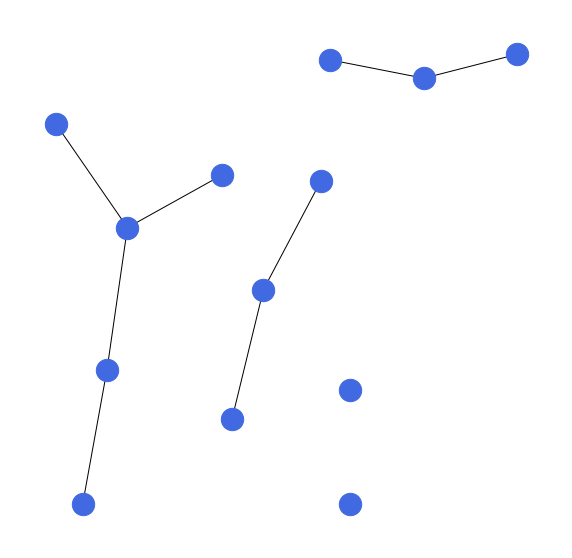

In [10]:
# Plot some randomly generated graphs
for i, g in enumerate(graph_samps_with_cont[:10]):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=nx.nx_pydot.graphviz_layout(g), ax=ax, node_size=500, node_color="royalblue")
    plt.show()

### Sample "true" graphs with and without conditional property

In [12]:
true_graphs_no_cond, true_graphs_with_cond = [], []

while len(true_graphs_with_cond) < mmd_sample_size * 2:
    for data in data_loader:
        graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
        
        if len(true_graphs_no_cond) < mmd_sample_size * 2:
            true_graphs_no_cond.extend(graphs)
            
        # Filter for property
        pass_vals = [
            (max(len(c) for c in nx.connected_components(g)) / len(g)) < 0.6
            for g in graphs
        ]
        
        if len(true_graphs_with_cond) < mmd_sample_size * 2:
            true_graphs_with_cond.extend([graphs[i] for i, p in enumerate(pass_vals) if p])
            
        if len(true_graphs_with_cond) >= mmd_sample_size * 2:
            break

true_graphs_no_cond = true_graphs_no_cond[:mmd_sample_size * 2]
true_graphs_with_cond = true_graphs_with_cond[:mmd_sample_size * 2]

0


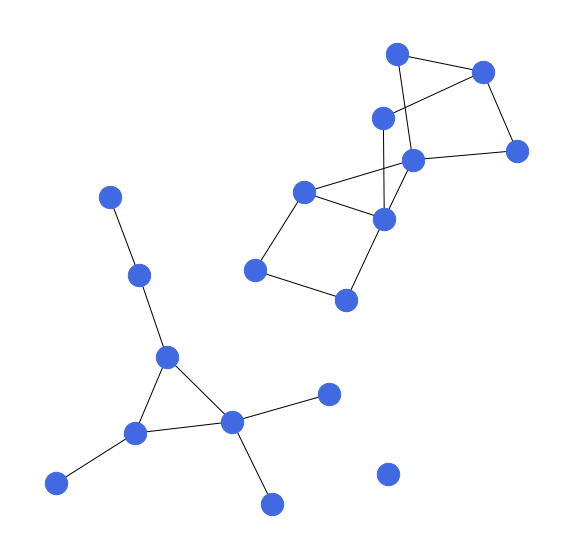

1


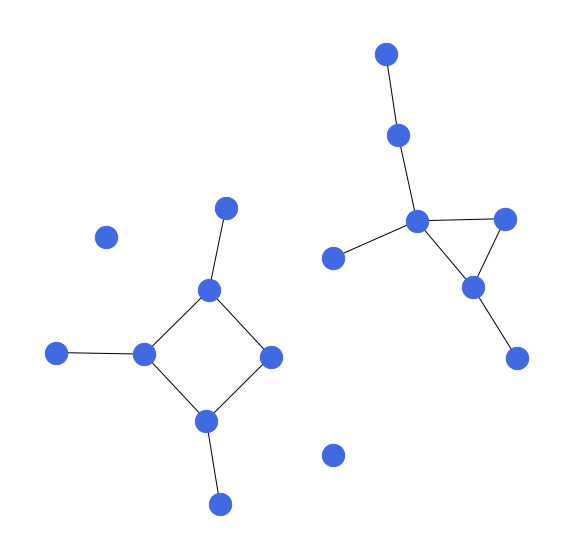

2


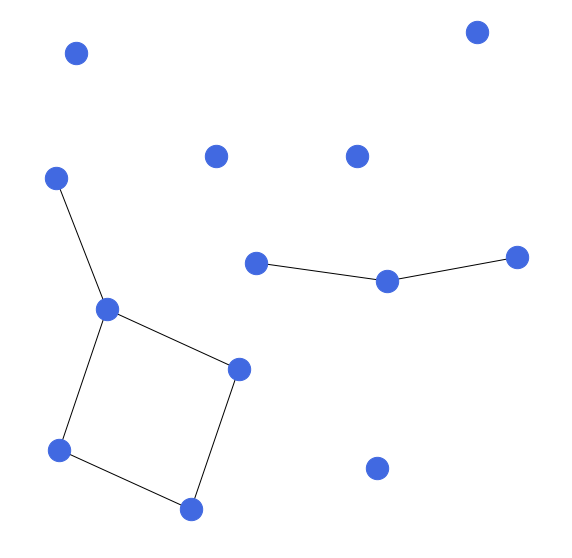

3


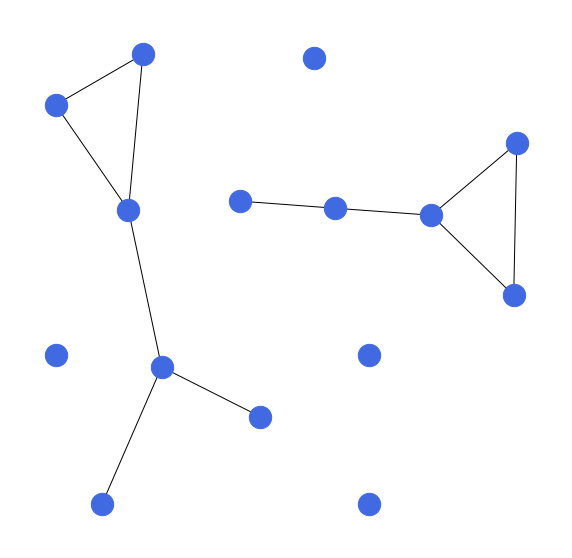

4


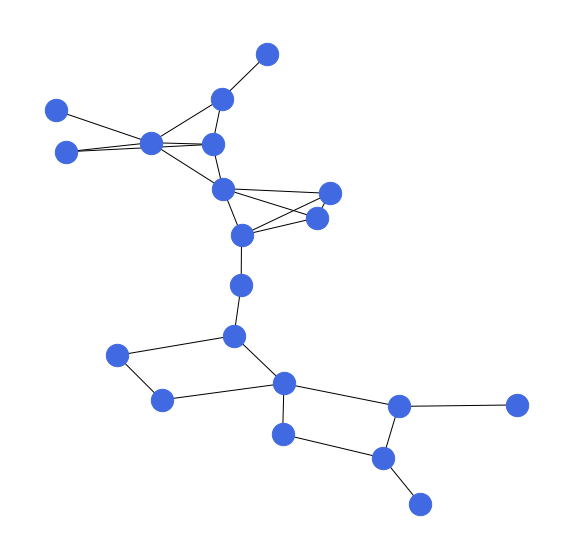

0


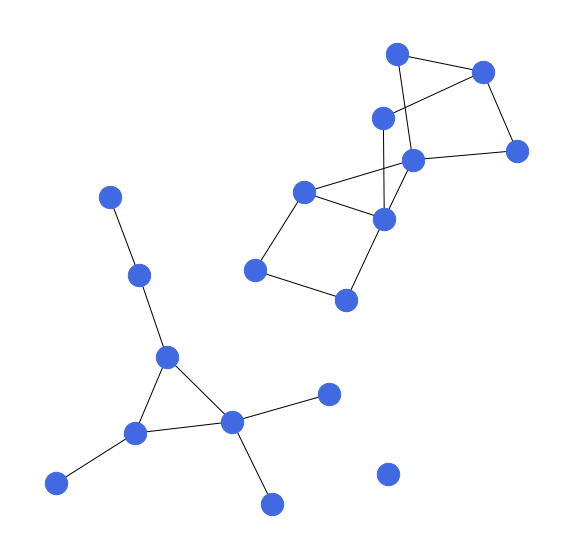

1


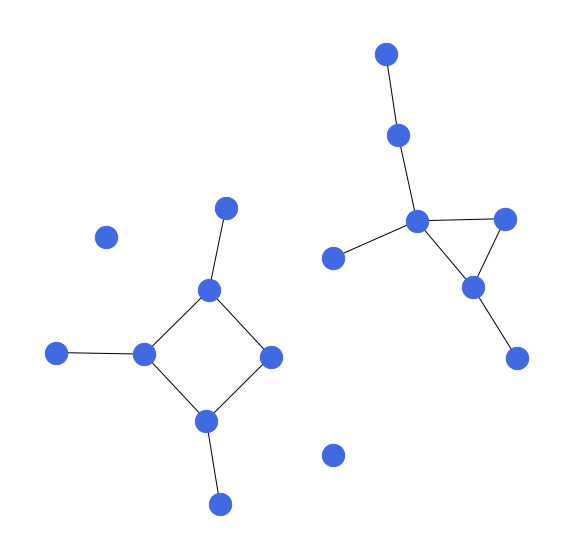

2


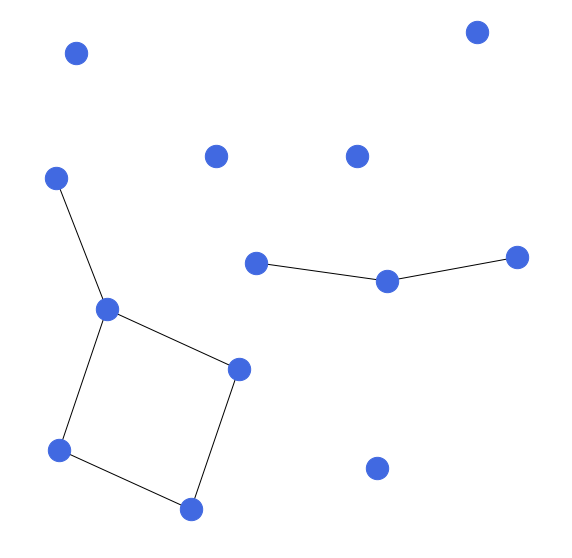

3


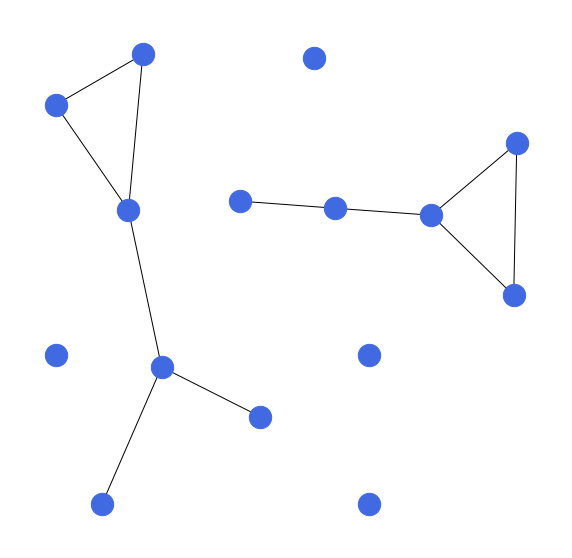

4


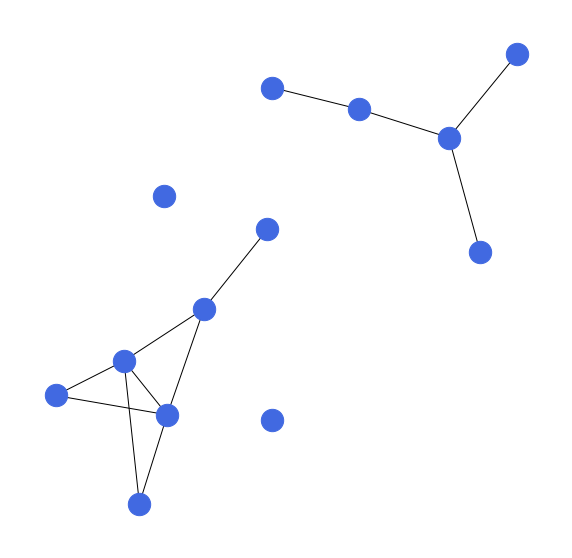

In [13]:
# Plot some randomly sampled graphs
for i, g in enumerate(true_graphs_no_cond[:5]):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=nx.nx_pydot.graphviz_layout(g), ax=ax, node_size=500, node_color="royalblue")
    plt.show()
for i, g in enumerate(true_graphs_with_cond[:5]):
    print(i)
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=nx.nx_pydot.graphviz_layout(g), ax=ax, node_size=500, node_color="royalblue")
    plt.show()

### Compute and visualize MMD

In [ ]:
def remove_singletons(graph):
    """
    Returns a copy of a NetworkX graph with singleton nodes removed.
    """
    result = graph.copy()
    to_delete = [n for n, d in result.degree() if not d]
    for n in to_delete:
        result.remove_node(n)
    return result

In [14]:
def compute_mmds(graphs_1, graphs_2, remove_singleton_nodes=False):
    """
    Given two lists of NetworkX graphs, computes various MMD metrics
    between the two sets of graphs. Returns a tuple of four MMD values:
        degree, clustering coefficient, spectrum, orbit
    If `remove_singletons` is True, remove all singleton nodes first.
    """
    print("Computing MMDs between %d vs %d graphs" % (len(graphs_1), len(graphs_2)))
    all_graphs = graphs_1 + graphs_2
    mid_index = len(graphs_1)
    
    if remove_singleton_nodes:
        all_graphs = [remove_singletons(graph) for graph in all_graphs]
    
    square_func = np.square
    kernel_type = "gaussian_total_variation"
    
    degree_hists = mmd.make_histograms(
        graph_metrics.get_degrees(all_graphs), bin_width=1
    )
    degree_mmd = square_func(mmd.compute_maximum_mean_discrepancy(
        degree_hists[:mid_index], degree_hists[mid_index:],
        kernel_type, sigma=1
    ))    
    cluster_coef_hists = mmd.make_histograms(
        graph_metrics.get_clustering_coefficients(all_graphs), num_bins=100
    )
    cluster_coef_mmd = square_func(mmd.compute_maximum_mean_discrepancy(
        cluster_coef_hists[:mid_index], cluster_coef_hists[mid_index:],
        kernel_type, sigma=0.1
    ))
    spectra_hists = mmd.make_histograms(
        graph_metrics.get_spectra(all_graphs),
        bin_array=np.linspace(-1e-5, 2, 200 + 1)
    )
    spectra_mmd = square_func(mmd.compute_maximum_mean_discrepancy(
        spectra_hists[:mid_index], spectra_hists[mid_index:],
        kernel_type, sigma=1
    ))
    orbit_counts = graph_metrics.get_orbit_counts(all_graphs)
    orbit_counts = np.stack([
        np.mean(counts, axis=0) for counts in orbit_counts
    ])
    orbit_mmd = square_func(mmd.compute_maximum_mean_discrepancy(
        orbit_counts[:mid_index], orbit_counts[mid_index:],
        kernel_type, normalize=False, sigma=30
    ))
    
    return (degree_mmd, cluster_coef_mmd, spectra_mmd, orbit_mmd)

In [15]:
uncond_mmds = compute_mmds(graph_samps_no_cont, true_graphs_no_cond[:mmd_sample_size])
uncond_baseline_mmds = compute_mmds(true_graphs_no_cond[:mmd_sample_size], true_graphs_no_cond[mmd_sample_size:])
cond_mmds = compute_mmds(graph_samps_with_cont, true_graphs_with_cond[:mmd_sample_size])
cond_baseline_mmds = compute_mmds(true_graphs_with_cond[:mmd_sample_size], true_graphs_with_cond[mmd_sample_size:])

Computing MMDs between 200 vs 200 graphs
Computing MMDs between 200 vs 200 graphs
Computing MMDs between 200 vs 200 graphs
Computing MMDs between 200 vs 200 graphs


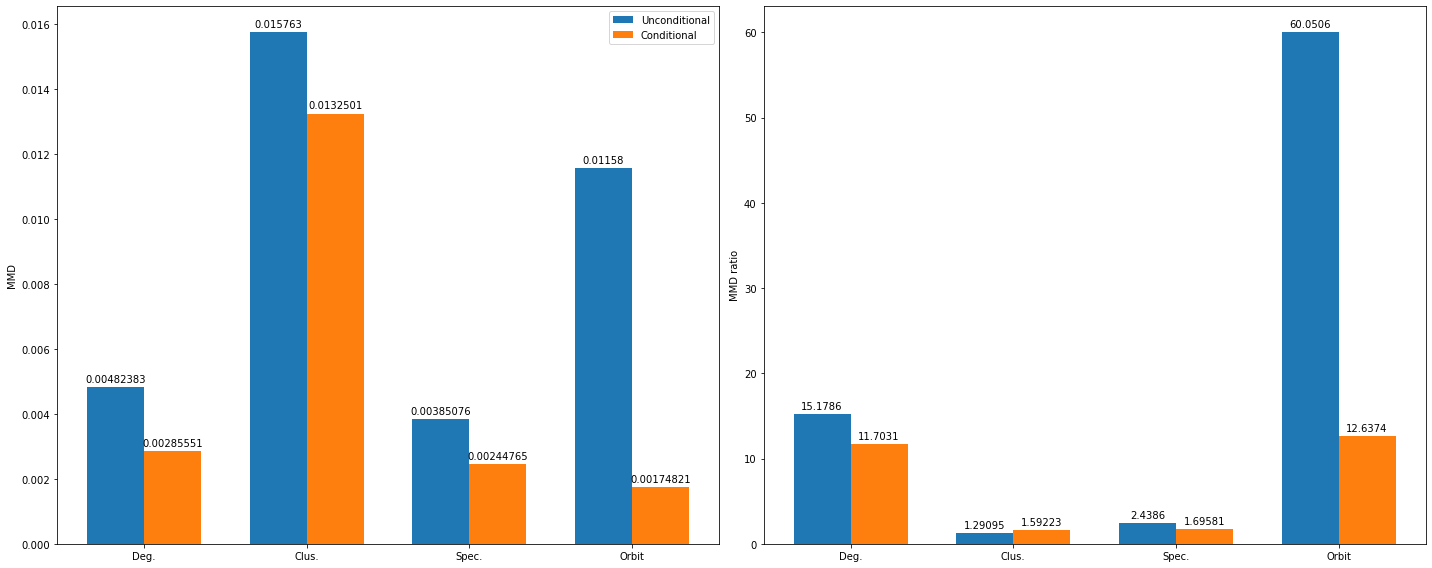

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

labels = ["Deg.", "Clus.", "Spec.", "Orbit"]

x = np.arange(len(labels))
width = 0.35

uncond_bars = ax[0].bar(x - (width / 2), uncond_mmds, width, label="Unconditional")
cond_bars = ax[0].bar(x + (width / 2), cond_mmds, width, label="Conditional")
ax[0].bar_label(uncond_bars, padding=3)
ax[0].bar_label(cond_bars, padding=3)
ax[0].set_ylabel("MMD")
ax[0].set_xticks(x, labels)
ax[0].legend()

uncond_ratios = [uncond_mmds[i] / uncond_baseline_mmds[i] for i in range(len(labels))]
cond_ratios = [cond_mmds[i] / cond_baseline_mmds[i] for i in range(len(labels))]
uncond_ratio_bars = ax[1].bar(x - (width / 2), uncond_ratios, width, label="Unconditional")
cond_ratio_bars = ax[1].bar(x + (width / 2), cond_ratios, width, label="Conditional")
ax[1].bar_label(uncond_ratio_bars, padding=3)
ax[1].bar_label(cond_ratio_bars, padding=3)
ax[1].set_ylabel("MMD ratio")
ax[1].set_xticks(x, labels)

fig.tight_layout()
plt.show()